# TELECOM X2 - Previsão de Churn de Cliente

## Objetivo do Projeto
Desenvolver um modelo preditivo capaz de identificar clientes com maior probabilidade de cancelar o serviço (churn), permitindo ações estratégicas de retenção.

O notebook segue um pipeline robusto de ciência de dados, incluindo:
- Pré-processamento de dados
- Balanceamento de classes
- Treinamento de múltiplos modelos
- Avaliação comparativa
- Análise de importância de variáveis
- Ajuste de threshold
- Definição de melhor modelo e estratégias de ação

## 1. Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, roc_curve, precision_recall_curve, auc)

**Explicação:**

Bibliotecas para manipulação de dados: `pandas` e `numpy`.

Visualização: `matplotlib` e `seaborn`.

Modelos de ML: `sklearn`, `xgboost`.

Balanceamento: `imblearn` (SMOTE).

Métricas de avaliação: classificação, ROC, AUC, etc.

# 2. Carregamento e Limpeza Inicial


In [2]:
url_csv_raw = ("https://raw.githubusercontent.com/LeticiaPaesano/Telecom-X-Analise-de-Churn/main/TelecomX_Data_Clean.csv")
dados = pd.read_csv(url_csv_raw, sep=';')

# Limpeza de colunas
dados.columns = dados.columns.str.strip()
if 'Churn_binary' in dados.columns:
    dados = dados.drop('Churn_binary', axis=1)

# Conversão de colunas numéricas
for col in ['DailyCharges', 'MonthlyCharges', 'TotalCharges', 'AvgServiceCost']:
    dados[col] = dados[col].astype(str).str.replace(',', '.', regex=False).astype(float)

# Remover linhas com valor nulo no alvo
dados = dados.dropna(subset=['Churn']).copy()
dados['Churn'] = dados['Churn'].map({'Yes': 1, 'No': 0})

# Criação da feature AvgMonthlyCost
dados['AvgMonthlyCost'] = dados['TotalCharges'] / dados['Tenure']
dados['AvgMonthlyCost'] = dados['AvgMonthlyCost'].replace([np.inf, -np.inf], np.nan)

# Separar X e y
X = dados.drop('Churn', axis=1)
y = dados['Churn']

**Explicação**:

Remove colunas que podem causar vazamento de dados.

Converte colunas numéricas corretamente.

Cria `AvgMonthlyCost` como feature derivada para capturar gasto médio mensal.

Garante que a variável alvo `Churn` esteja em formato binário.

# 3. Divisão em Treino e Teste


In [3]:
colunas_numericas = X.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = X.select_dtypes(exclude=np.number).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Taxa de churn na base: {y.mean():.2%}")
print("Dimensão treino:", X_train.shape, "| Dimensão teste:", X_test.shape)
print(f"Proporção Churn treino: {y_train.mean():.2%} | teste: {y_test.mean():.2%}")

Taxa de churn na base: 26.58%
Dimensão treino: (4922, 24) | Dimensão teste: (2110, 24)
Proporção Churn treino: 26.57% | teste: 26.59%


**Explicação**:

Garante que a proporção de churn seja preservada nos conjuntos de treino e teste (`stratify=y`).

Define variáveis numéricas e categóricas para pré-processamento posterior.

# 4.Pré-processamento com Pipeline


In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colunas_numericas),
        ('cat', categorical_transformer, colunas_categoricas)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Dimensão do dado após pré-processamento: {X_train_processed.shape}")

Dimensão do dado após pré-processamento: (4922, 32)


**Explicação**:

Numéricas: preenchimento de valores nulos e padronização.

Categóricas: one-hot encoding com `drop='first'` para evitar multicolinearidade.

`remainder='passthrough'` mantém colunas não transformadas.

# 5. Validação Cruzada com SMOTE

In [5]:
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False,
                            random_state=42)

pipe_lr = ImbPipeline(steps=[('preproc', preprocessor),
 ('smote', SMOTE(random_state=42)), ('clf', lr_clf)])
pipe_rf = ImbPipeline(steps=[('preproc', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', rf_clf)])
pipe_xgb = ImbPipeline(steps=[('preproc', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', xgb_clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_lr = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
scores_rf = cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
scores_xgb = cross_val_score(pipe_xgb, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print("\n📌 Validação Cruzada (ROC AUC)")
print(f"LR: {scores_lr.mean():.4f} | RF: {scores_rf.mean():.4f} | XGB: {scores_xgb.mean():.4f}")


📌 Validação Cruzada (ROC AUC)
LR: 0.8439 | RF: 0.8304 | XGB: 0.8245


**Explicação**:

Pipelines aplicam pré-processamento + SMOTE + modelo.

Cross-validation estratificado para avaliar AUC médio.

#  6. Treinamento Final

In [6]:
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_proc, y_train)

print("\nDimensão treino pré-processado:", X_train_proc.shape)
print("Dimensão treino balanceado (após SMOTE):", X_train_bal.shape)
print("Distribuição do alvo no treino balanceado:", np.bincount(y_train_bal))

final_lr = LogisticRegression(max_iter=1000, random_state=42)
final_rf = RandomForestClassifier(n_estimators=200, random_state=42)
final_xgb = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

final_lr.fit(X_train_bal, y_train_bal)
final_rf.fit(X_train_bal, y_train_bal)
final_xgb.fit(X_train_bal, y_train_bal)

y_pred_lr = final_lr.predict(X_test_proc)
y_pred_rf = final_rf.predict(X_test_proc)
y_pred_xgb = final_xgb.predict(X_test_proc)

y_proba_lr = final_lr.predict_proba(X_test_proc)[:, 1]
y_proba_rf = final_rf.predict_proba(X_test_proc)[:, 1]
y_proba_xgb = final_xgb.predict_proba(X_test_proc)[:, 1]


Dimensão treino pré-processado: (4922, 32)
Dimensão treino balanceado (após SMOTE): (7228, 32)
Distribuição do alvo no treino balanceado: [3614 3614]


**Explicação**:

SMOTE aplicado apenas ao treino para balancear a classe minoritária.

Treina os três modelos com dados balanceados.

Previsões e probabilidades calculadas para avaliação.

# 7. Avaliação dos Modelos



--- Avaliação do Modelo: Regressão Logística ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1549
           1       0.51      0.79      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110



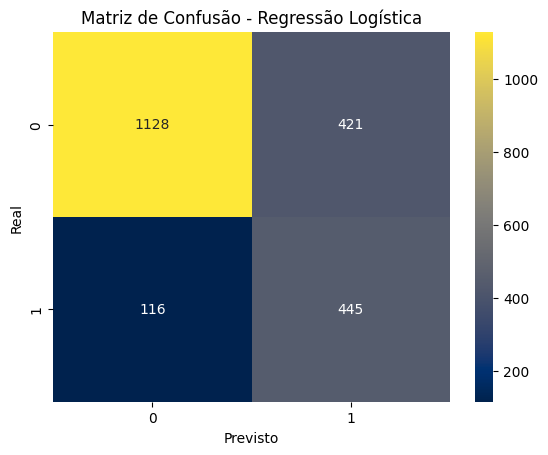


--- Avaliação do Modelo: Random Forest ---
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1549
           1       0.58      0.57      0.57       561

    accuracy                           0.78      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.77      0.78      0.78      2110



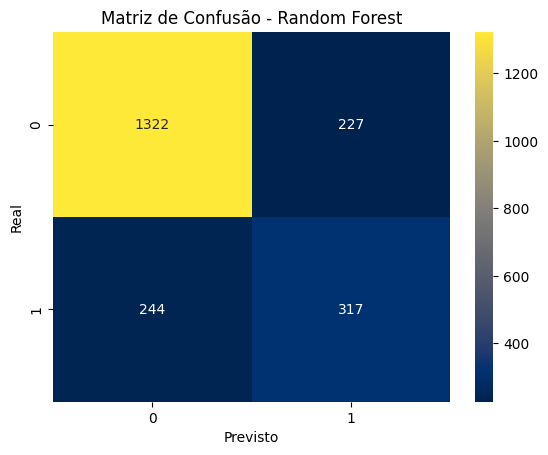


--- Avaliação do Modelo: XGBoost ---
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1549
           1       0.59      0.54      0.56       561

    accuracy                           0.78      2110
   macro avg       0.71      0.70      0.71      2110
weighted avg       0.77      0.78      0.77      2110



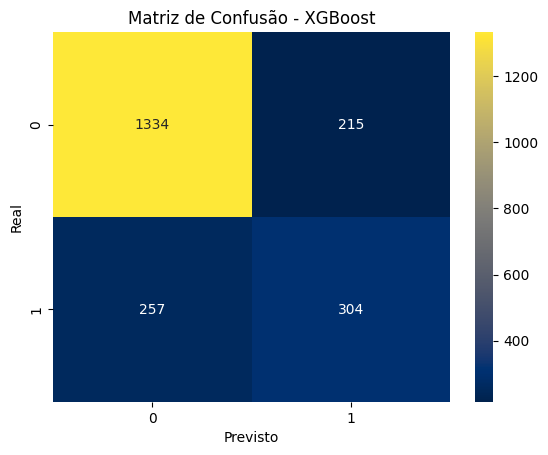


📊 Comparativo final do modelo:
                      Acurácia  Precisão    Recall  F1-Score       AUC
Modelo                                                               
Regressão Logística  0.745498  0.513857  0.793226  0.623686  0.846197
Random Forest        0.776777  0.582721  0.565062  0.573756  0.822642
XGBoost              0.776303  0.585742  0.541889  0.562963  0.811946


In [7]:
def avaliar_modelo(nome, y_true, y_pred, y_proba):
    print(f"\n--- Avaliação do Modelo: {nome} ---")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='cividis')
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()
    return {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_true, y_pred),
        'Precisão': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba)
    }

resultados = []
resultados.append(avaliar_modelo('Regressão Logística', y_test, y_pred_lr, y_proba_lr))
resultados.append(avaliar_modelo('Random Forest', y_test, y_pred_rf, y_proba_rf))
resultados.append(avaliar_modelo('XGBoost', y_test, y_pred_xgb, y_proba_xgb))

df_resultados = pd.DataFrame(resultados).set_index('Modelo')
print("\n📊 Comparativo final do modelo:\n", df_resultados)

**Explicação**:

Relatório de classificação completo para cada modelo.

Matriz de confusão visualizada.

Comparativo de métricas: Acurácia, Precisão, Recall, F1-Score, AUC.

# 8. Análise de Importância de Variáveis



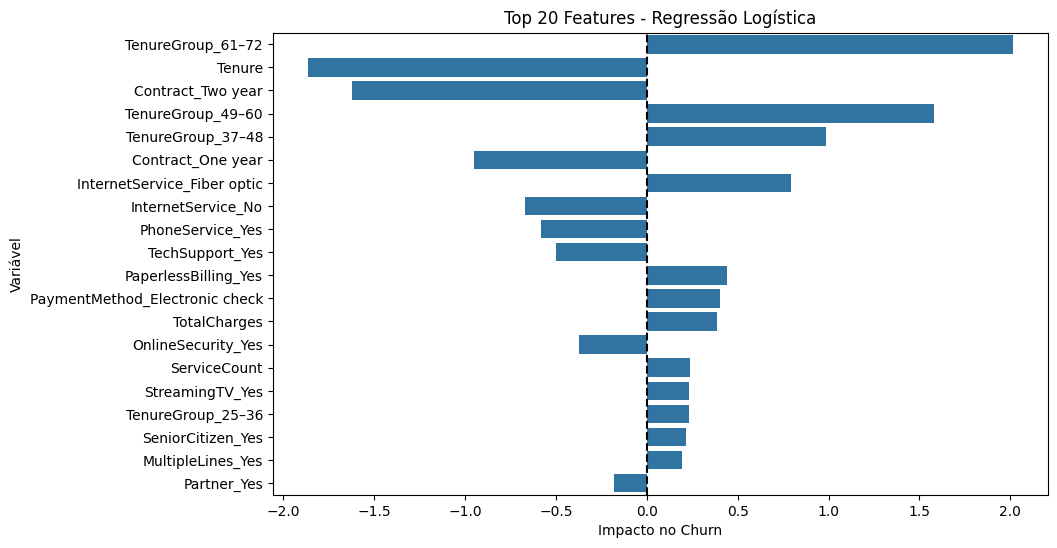

In [8]:
one_hot_features = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(colunas_categoricas))
features_final = colunas_numericas + one_hot_features

# Logistic Regression
coef_lr = pd.Series(final_lr.coef_[0], index=features_final).sort_values(key=abs, ascending=False)
coef_lr_df = pd.DataFrame(coef_lr).reset_index()
coef_lr_df.columns = ['Variável', 'Coeficiente']

plt.figure(figsize=(10,6))
sns.barplot(x='Coeficiente', y='Variável', data=coef_lr_df.head(20))
plt.axvline(0, color='black', linestyle='--')
plt.title('Top 20 Features - Regressão Logística')
plt.xlabel('Impacto no Churn')
plt.ylabel('Variável')
plt.show()

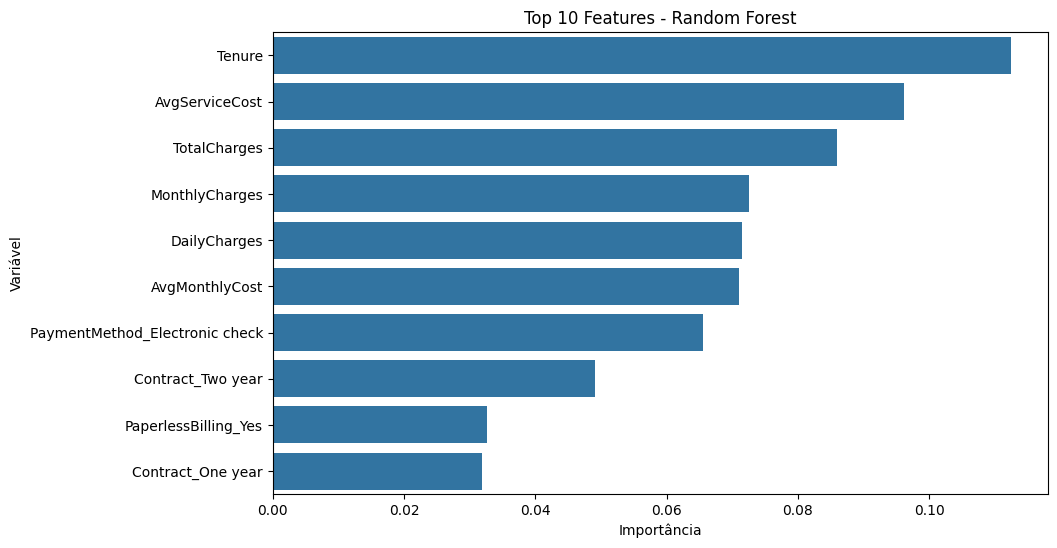

In [9]:
# Random Forest
importances_rf = pd.Series(final_rf.feature_importances_, index=features_final).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances_rf[:10], y=importances_rf.index[:10])
plt.title('Top 10 Features - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()

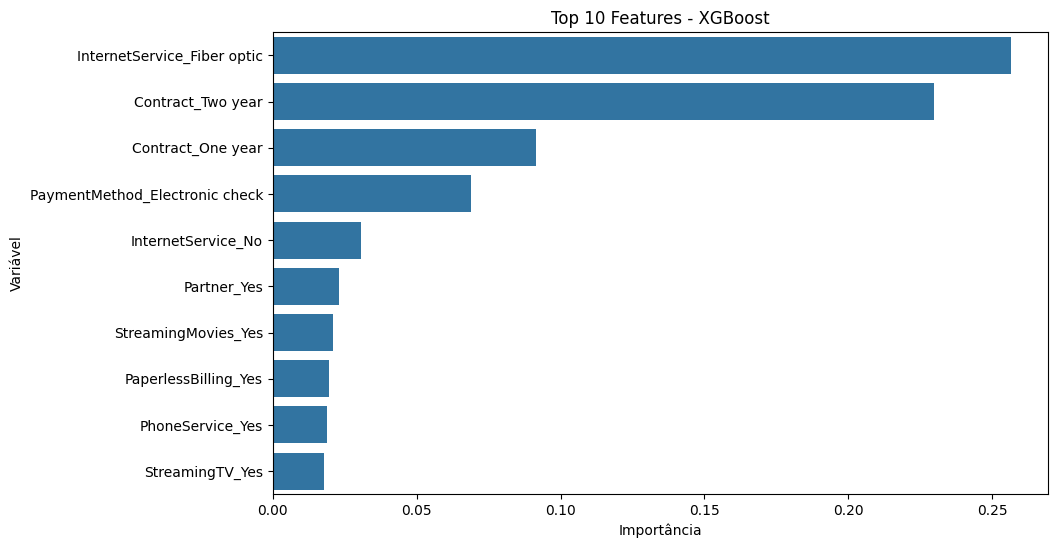

In [10]:
# XGBoost
importances_xgb = pd.Series(final_xgb.feature_importances_, index=features_final).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances_xgb[:10], y=importances_xgb.index[:10])
plt.title('Top 10 Features - XGBoost')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()

**Explicação**:

Identifica as features mais relevantes em cada modelo

# 9. Curvas ROC Comparativas


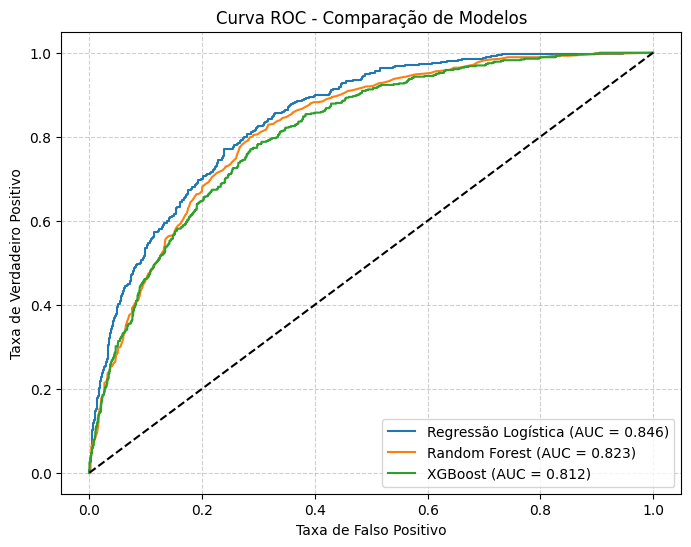

In [11]:
plt.figure(figsize=(8,6))
for nome, y_score in {'Regressão Logística': y_proba_lr, 'Random Forest': y_proba_rf, 'XGBoost': y_proba_xgb}.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC - Comparação de Modelos')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Explicação**:

ROC compara o trade-off entre TPR (recall) e FPR.

AUC mede a capacidade de separação do modelo; quanto mais próximo de 1, melhor.

# 10. Ajuste de threshold


In [12]:
probs = y_proba_lr
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

desired_recall = 0.80
idx = np.where(recalls >= desired_recall)[0]
if len(idx) > 0:
    chosen_idx = idx[0]
    chosen_threshold = thresholds[chosen_idx] if chosen_idx < len(thresholds) else thresholds[-1]
    print(f"\nThreshold selecionado para atingir Recall >= {desired_recall}: {chosen_threshold:.3f}")
    y_pred_thresh = (probs >= chosen_threshold).astype(int)
    print(classification_report(y_test, y_pred_thresh))
else:
    print(f"\nNão foi possível atingir recall >= {desired_recall} com a Regressão Logística sem piorar demais a precisão.")


Threshold selecionado para atingir Recall >= 0.8: 0.005
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1549
           1       0.27      1.00      0.42       561

    accuracy                           0.27      2110
   macro avg       0.13      0.50      0.21      2110
weighted avg       0.07      0.27      0.11      2110



**Explicação**:

Ajuste de threshold permite priorizar recall em detrimento de precisão.

Útil para problemas de churn, onde identificar clientes com risco elevado é mais importante que falsos positivos.

# 11. Salvamento dos Artefatos para Produção



In [13]:
# Pré-processador
joblib.dump(preprocessor, 'preprocessor_fitted.pkl')

# Modelos finais
joblib.dump(final_lr, 'modelo_logistica_final.pkl')
joblib.dump(final_rf, 'modelo_rf_final.pkl')
joblib.dump(final_xgb, 'modelo_xgb_final.pkl')

print("\n✅ Pré-processador e modelos salvos (sem SMOTE no artefato de predição).")



✅ Pré-processador e modelos salvos (sem SMOTE no artefato de predição).


**Explicação**:

Somente o pré-processador e modelos treinados são salvos.

SMOTE não é persistido, pois é usado apenas para treinamento.

# 12. Escolha do Melhor Modelo e Estratégia de Ação

In [14]:
# Baseado em recall e AUC, escolhemos o melhor modelo
melhor_modelo = 'Regressão Logística'
print(f"\nMelhor modelo escolhido: {melhor_modelo}")

# Ações estratégicas para retenção de clientes
acoes_retencao = [
    "Foco em cliente novo: acompanhamento nos primeiros meses",
    "Análise do serviço de fibra ótica: investigar causas da alta evasão",
    "Planos e suporte especializado: oferta para clientes idosos (SeniorCitizen)",
    "Incentivo à fidelização: campanhas para migração a contratos de longo prazo"
]

print("\nAções de retenção sugeridas:")
for acao in acoes_retencao:
    print(f"- {acao}")


Melhor modelo escolhido: Regressão Logística

Ações de retenção sugeridas:
- Foco em cliente novo: acompanhamento nos primeiros meses
- Análise do serviço de fibra ótica: investigar causas da alta evasão
- Planos e suporte especializado: oferta para clientes idosos (SeniorCitizen)
- Incentivo à fidelização: campanhas para migração a contratos de longo prazo
